In [1]:
from icl.util_classes.arg_classes import ShallowArgs, DeepArgs, CompressArgs
from sklearn.metrics import accuracy_score
import numpy as np

change ShallowArgs to ShallowNonLabelArgs if you want to get the results of that

In [2]:
def get_label(y):
    return y.predictions[0].argmax(-1)

def get_logits(y):
    if y.predictions[2].shape[-1] > 30000:
        return y.predictions[2]
    else:
        return y.predictions[3]

def get_topk(y, k):
    logits = get_logits(y)
    indices = np.argpartition(logits, -k,axis=1)[:,-k:]
    return indices

def jaccard(a,b):
    scores = []
    for single_a, single_b in zip(a,b):
        set_a = set(single_a)
        set_b = set(single_b)
        score = len(set_a.intersection(set_b))/len(set_a.union(set_b))
        scores.append(score)
    return np.array(scores).mean()

In [8]:
from tqdm import tqdm
import numpy as np
from icl.utils.load_huggingface_dataset import load_huggingface_dataset_train_and_test
import warnings

def calculate_average_scores(seeds, task_name,sample_size=1000,model_name='gpt2-xl',mask_layer_num=5,demonstration_shot=1):
    scores = []  
    jaccards = []
    dataset = load_huggingface_dataset_train_and_test(task_name)
    if len(dataset['test']) < sample_size:
        warnings.warn(
            f"sample_size: {sample_size} is larger than test set size: {len(dataset['test'])},"
            f"actual_sample_size is {len(dataset['test'])}")
        actual_sample_size = len(dataset['test'])
    else:
        actual_sample_size = sample_size
    
    for seed in tqdm(seeds):
        args = ShallowArgs(task_name=task_name, seeds=[seed],sample_size=sample_size,model_name=model_name,
            mask_layer_pos='first',mask_layer_num=mask_layer_num,demonstration_shot=demonstration_shot)
        y_first, = args.load_result()[0]
        args = ShallowArgs(task_name=task_name, seeds=[seed],sample_size=sample_size,model_name=model_name,
            mask_layer_pos='last',mask_layer_num=mask_layer_num,demonstration_shot=demonstration_shot)
        y_last, = args.load_result()[0]
        try:
            args = CompressArgs(task_name=task_name, seeds=[seed],sample_size=sample_size,
            model_name=model_name,demonstration_shot=demonstration_shot)
            _, y_true, _, _ = args.load_result()[0]
        except KeyboardInterrupt:
            break
        except:
            args = DeepArgs(task_name=task_name, seeds=[seed],sample_size=sample_size,
            model_name=model_name,demonstration_shot=demonstration_shot)
            y_true, = args.load_result()[0]
            
        label_first, label_last, label_true = [get_label(_) for _ in [y_first,y_last,y_true]]

        score_first = accuracy_score(label_true, label_first)
        score_last = accuracy_score(label_true, label_last)
        score_true = accuracy_score(label_true, label_true)
        
        scores.append((score_first, score_last, score_true))

        jaccard_first = jaccard(get_topk(y_true, 10), get_topk(y_first, 10))
        jaccard_last = jaccard(get_topk(y_true, 10), get_topk(y_last, 10))
        jaccard_true = jaccard(get_topk(y_true, 10), get_topk(y_true, 10))
        jaccards.append((jaccard_first, jaccard_last, jaccard_true))


    average_scores = np.mean(scores, axis=0) 
    accuracy_jaccards = np.mean(jaccards, axis=0)
    return average_scores, accuracy_jaccards

In [11]:
model_name = 'gpt2-xl'
layers = [5]#[1,3,5,7]
demonstration_shot = 1

tables = []
for layer in layers:
    seeds = [42]#,43,44,45 ,46]
    tasks = ['sst2']#, 'agnews', 'trec', 'emo']
    single_table = []

    for task in tqdm(tasks):
        average_scores = calculate_average_scores(seeds, task,sample_size=1000,model_name=model_name,mask_layer_num=layer,demonstration_shot=demonstration_shot)
        row = [task] + list(average_scores)
        single_table.append(row)

    header = ['Task', 'label loyalty','word loyalty']
    tables.append(single_table)

  0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_2925623/2339093410.py:11: UserWarning: sample_size: 1000 is larger than test set size: 872,actual_sample_size is 872
  warnings.warn(
100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


In [12]:
data = np.array(np.array([[_[1:] for _ in table] for table in tables])) # omit task name

In [14]:
data

array([[[[0.52866972, 1.        , 1.        ],
         [0.00102607, 0.99499583, 1.        ]]]])

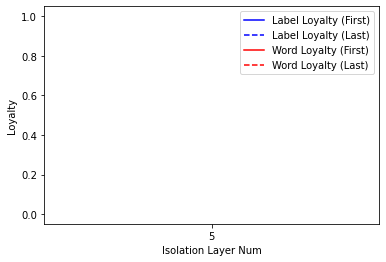

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

mean_data = data.mean(1)
layer_num, metric_num, _ = mean_data.shape
colors = ['b', 'r', 'g']
linestyles = ['-', '--']
Metric_name = ['Label Loyalty', 'Word Loyalty']

fig, ax = plt.subplots()

for i in range(metric_num):
    for j in range(2):
        ax.plot(range(layer_num), mean_data[:, i, j], color=colors[i], linestyle=linestyles[j])

handles = []
labels = []
for i in range(metric_num):
    handles.append(plt.Line2D([], [], color=colors[i], linestyle='-'))
    labels.append(f'%s (First)' % Metric_name[i])
    handles.append(plt.Line2D([], [], color=colors[i], linestyle='--'))
    labels.append(f'%s (Last)' % Metric_name[i])

ax.legend(handles, labels)

ax.set_xlabel('Isolation Layer Num')
ax.set_ylabel('Loyalty')

xticks = list(map(str,layers))
ax.set_xticks(range(layer_num))
ax.set_xticklabels(xticks)

plt.show()
fig.savefig(f'aggregation_loyalty_{model_name}_{demonstration_shot}.pdf', dpi=300, bbox_inches='tight')